# PROPHET

### IMPORTS

In [ ]:
# Ejecutar en Anaconda Prompt
!conda install -c conda-forge prophet

In [1]:
import time
import pandas as pd
import numpy as np

from math import sqrt
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt
from itertools import product
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric

Importing plotly failed. Interactive plots will not work.


### CARGA DE COMPLETE RETURNS Y RENTALS

In [2]:
completeRentalsDf = pd.read_csv('../data/completeData/rentals/completeRentalsDf_EXOGVAR.csv')
completeReturnsDf = pd.read_csv('../data/completeData/returns/completeReturnsDf_EXOGVAR.csv')

In [ ]:
completeRentalsDf = pd.read_csv('../data/completeData/rentals/completeRentalsDf_LOG1P_EXOGVAR.csv')
completeReturnsDf = pd.read_csv('../data/completeData/returns/completeReturnsDf_LOG1P_EXOGVAR.csv')

### TRAIN-VALIDATION-TEST SPLIT

In [3]:
TRAIN_DAYS = 4000
TEST_DAYS = 102
STATION = '31201'

In [4]:
df_train = completeRentalsDf.filter(['Date', STATION], axis=1)
df_train = df_train.loc[0:TRAIN_DAYS*24-1]
df_train.rename(columns={"Date": "ds", STATION: "y"}, inplace=True)

df_train_exog = completeRentalsDf.filter(['temp', 'humidity', STATION+'_lag24', STATION+'_lag48', STATION+'_lag168'], axis=1)
df_train_exog = df_train_exog.loc[0:TRAIN_DAYS*24-1]

df_train = pd.concat([df_train, df_train_exog], axis=1, join="inner")

df_train.head(10)

,ds,y,temp,humidity,31201_lag24,31201_lag48,31201_lag168
0,2010-09-27 00:00:00,0,19.0,72.28,0.0,0.0,0.0
1,2010-09-27 01:00:00,0,17.8,88.03,0.0,0.0,0.0
2,2010-09-27 02:00:00,0,17.8,88.03,0.0,0.0,0.0
3,2010-09-27 03:00:00,0,17.9,89.30,0.0,0.0,0.0
4,2010-09-27 04:00:00,0,17.9,93.58,0.0,0.0,0.0
5,2010-09-27 05:00:00,0,18.1,93.60,0.0,0.0,0.0
6,2010-09-27 06:00:00,0,18.9,89.38,0.0,0.0,0.0
7,2010-09-27 07:00:00,0,19.1,94.17,0.0,0.0,0.0
8,2010-09-27 08:00:00,1,20.0,93.68,0.0,0.0,0.0
9,2010-09-27 09:00:00,0,21.8,94.29,0.0,1.0,0.0


In [5]:
df_validation = completeRentalsDf.filter(['Date', STATION], axis=1)
df_validation = df_validation.loc[TRAIN_DAYS*24:len(df_validation)-TEST_DAYS*24-1]
df_validation.rename(columns={"Date": "ds", STATION:"y"}, inplace=True)

df_validation_exog = completeRentalsDf.filter(['temp', 'humidity', STATION+'_lag24', STATION+'_lag48', STATION+'_lag168'], axis=1)
df_validation_exog = df_validation_exog.loc[TRAIN_DAYS*24:len(df_validation_exog)-TEST_DAYS*24-1]

df_validation = pd.concat([df_validation, df_validation_exog], axis=1, join="inner")

df_validation.head(10)

,ds,y,temp,humidity,31201_lag24,31201_lag48,31201_lag168
96000,2021-09-09 00:00:00,1,24.8,77.31,1.0,0.0,1.0
96001,2021-09-09 01:00:00,0,23.6,75.26,0.0,0.0,0.0
96002,2021-09-09 02:00:00,0,22.8,75.93,0.0,4.0,2.0
96003,2021-09-09 03:00:00,0,22.1,81.64,0.0,0.0,0.0
96004,2021-09-09 04:00:00,0,21.1,89.72,0.0,0.0,0.0
96005,2021-09-09 05:00:00,0,21.0,87.48,0.0,0.0,1.0
96006,2021-09-09 06:00:00,4,21.0,87.59,3.0,3.0,0.0
96007,2021-09-09 07:00:00,5,21.0,87.72,4.0,8.0,9.0
96008,2021-09-09 08:00:00,4,21.1,87.66,11.0,10.0,7.0
96009,2021-09-09 09:00:00,5,21.1,87.62,7.0,5.0,4.0


In [6]:
df_test = completeRentalsDf.filter(['Date', STATION], axis=1)
df_test = df_test.loc[len(df_test)-TEST_DAYS*24:len(df_test)-1]
df_test.rename(columns={"Date": "ds", STATION:"y"}, inplace=True)

df_test_exog = completeRentalsDf.filter(['temp', 'humidity', STATION+'_lag24', STATION+'_lag48', STATION+'_lag168'], axis=1)
df_test_exog = df_test_exog.loc[len(df_test_exog)-TEST_DAYS*24-1:len(df_test_exog)-1]

df_test = pd.concat([df_test, df_test_exog], axis=1, join="inner")

df_test.head(10)

,ds,y,temp,humidity,31201_lag24,31201_lag48,31201_lag168
98448,2021-12-20 00:00:00,0,1.4,59.09,0.0,2.0,0.0
98449,2021-12-20 01:00:00,0,0.4,63.23,1.0,0.0,0.0
98450,2021-12-20 02:00:00,0,-0.1,65.87,0.0,8.0,0.0
98451,2021-12-20 03:00:00,0,-0.9,66.66,1.0,3.0,0.0
98452,2021-12-20 04:00:00,0,-1.3,66.55,0.0,0.0,0.0
98453,2021-12-20 05:00:00,1,-1.9,67.02,0.0,0.0,1.0
98454,2021-12-20 06:00:00,3,-1.5,64.91,0.0,0.0,2.0
98455,2021-12-20 07:00:00,0,-2.4,69.45,0.0,0.0,4.0
98456,2021-12-20 08:00:00,3,-2.0,67.31,1.0,1.0,7.0
98457,2021-12-20 09:00:00,5,-1.5,64.98,3.0,0.0,4.0


In [7]:
df_future_validation = df_validation.drop(columns=['y'])
df_future_test = df_test.drop(columns=['y'])

In [16]:
def plotDayPrediction(predictions, Y, day):

    data = pd.DataFrame()
    try:
        data['prediction'] = np.round(predictions[day*24:day*24+24],0)
        data['real'] = Y[day*24:day*24+24]
    except:
        print("El dia tiene que ser inferior a {}".format(len(Y)/24) )

    plt.figure(figsize=(15,5))
    plt.xlabel('Prediccion del día {}'.format(day))
    plt.ylabel('Nº Alquileres')
    ax1 = data.real.plot(color='blue', grid=True, label='Alquileres reales')
    ax2 = data.prediction.plot(color='red', grid=True, label='Predicciones')
    h1, l1 = ax1.get_legend_handles_labels()

    plt.legend(h1, l1, loc=2)
    plt.show()

### MODEL

In [9]:
model = Prophet(changepoint_prior_scale=0.5, seasonality_prior_scale=0.01, holidays_prior_scale=1 , yearly_seasonality=True, weekly_seasonality=True)
model.add_country_holidays(country_name='US')

for columName in df_future_validation:
    if columName != 'ds' and columName != 'cap': model.add_regressor(columName)

model.fit(df_train)

In [10]:
forecast = model.predict(df_future_validation)
forecast['y'] = df_validation['y'].values
print("Validation RMSE = {}".format(sqrt(mean_squared_error(forecast['yhat'], forecast['y']))))

Validation RMSE = 2.680785391245489


Test RMSE = 2.171945567897869


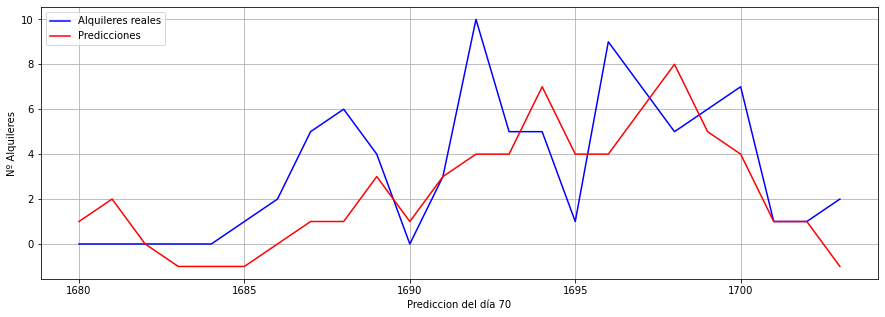

In [17]:
forecast = model.predict(df_future_test)
forecast['y'] = df_test['y'].values
print("Test RMSE = {}".format(sqrt(mean_squared_error(forecast['yhat'], forecast['y']))))
plotDayPrediction(forecast['yhat'], forecast['y'], 70)

### CROSS-VALIDATION

In [29]:
starttime = time.time()
df_cv = cross_validation(model, initial='3900 days', period='40 days', horizon = '7 days', parallel="processes")
print(f'Time: {time.time() - starttime}')
df_cv.head(10)

INFO:prophet:Making 3 forecasts with cutoffs between 2021-06-07 23:00:00 and 2021-08-26 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001C49C3B0100>


Time: 337.9009985923767


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2021-06-08 00:00:00,0.161977,-4.195221,4.231981,1,2021-06-07 23:00:00
1,2021-06-08 01:00:00,0.191142,-4.017575,4.080262,2,2021-06-07 23:00:00
2,2021-06-08 02:00:00,-0.491237,-4.977603,3.741172,0,2021-06-07 23:00:00
3,2021-06-08 03:00:00,-1.406706,-5.780580,2.928596,0,2021-06-07 23:00:00
4,2021-06-08 04:00:00,-1.413844,-6.038501,2.692990,0,2021-06-07 23:00:00
5,2021-06-08 05:00:00,-0.169960,-4.670825,4.008481,0,2021-06-07 23:00:00
6,2021-06-08 06:00:00,1.885127,-2.479671,6.120547,3,2021-06-07 23:00:00
7,2021-06-08 07:00:00,3.969245,-0.148615,8.299725,5,2021-06-07 23:00:00
8,2021-06-08 08:00:00,4.498279,0.123168,9.232231,6,2021-06-07 23:00:00
9,2021-06-08 09:00:00,3.538621,-0.855499,7.630498,1,2021-06-07 23:00:00


In [30]:
df_p = performance_metrics(df_cv)
df_p.head()

INFO:prophet:Skipping MAPE because y close to 0


,horizon,mse,rmse,mae,mdape,smape,coverage
0,0 days 17:00:00,6.438704,2.537460,2.092562,0.728272,1.061926,0.920000
1,0 days 18:00:00,6.473183,2.544245,2.087877,0.596764,0.984533,0.920000
2,0 days 19:00:00,6.609048,2.570807,2.129145,0.552990,0.898176,0.926667
3,0 days 20:00:00,7.153338,2.674572,2.136441,0.515885,0.794427,0.920000
4,0 days 21:00:00,6.881454,2.623253,2.061816,0.440217,0.681928,0.920000


In [31]:
df_p.tail()

,horizon,mse,rmse,mae,mdape,smape,coverage
147,6 days 20:00:00,8.059197,2.838873,2.236019,0.451596,0.812659,0.900000
148,6 days 21:00:00,7.934934,2.816901,2.190432,0.418194,0.710986,0.900000
149,6 days 22:00:00,8.213932,2.865996,2.202360,0.382195,0.613809,0.880000
150,6 days 23:00:00,8.129100,2.851158,2.183841,0.369456,0.558044,0.880000
151,7 days 00:00:00,8.756251,2.959096,2.294456,0.401066,0.609070,0.846667


In [32]:
print("Cross-Validation RMSE = {}".format(df_p['rmse'].values.mean()))

Cross-Validation RMSE = 2.9753622589438735


C:\Users\User\anaconda3\envs\TFG-GPU\lib\site-packages\prophet\plot.py:539: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])
C:\Users\User\anaconda3\envs\TFG-GPU\lib\site-packages\prophet\plot.py:540: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])


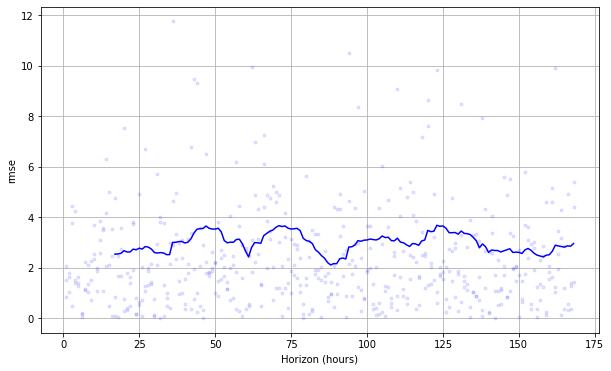

In [33]:
fig = plot_cross_validation_metric(df_cv, metric='rmse')

### HYPERPARAMETER TUNNING - LOG1P DATA

In [22]:
param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 0.5, 1, 3, 10],
    'holidays_prior_scale': [0.01, 0.1, 0.5, 1, 3, 10],
    #'seasonality_mode': ['additive', 'multiplicative'],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in product(*param_grid.values())]
mses, rmses, maes, smapes, coverages = [], [], [], [], []


def cross_val(i, params, totalParams):
    print("INICIO Iteracion Nº {}/{}".format(i, totalParams))
    starttime = time.time()
    model = Prophet(**params)
    for columnName in df_future:
        if columnName != 'ds' and columnName != 'cap': model.add_regressor(columnName)
    model.fit(df_train)

    df_cv = cross_validation(model, initial='3400 days', period='365 days', horizon = '2 days', parallel="processes")
    df_p = performance_metrics(df_cv)
    mses.append(df_p['mse'].values.mean())
    rmses.append(df_p['rmse'].values.mean())
    maes.append(df_p['mae'].values.mean())
    smapes.append(df_p['smape'].values.mean())
    coverages.append(df_p['coverage'].values.mean())
    print("FIN Iteracion Nº {}/{} en {} segundos".format(i, totalParams, time.time()-starttime))

# Use cross validation to evaluate all parameters
for i, params in enumerate(all_params):
    cross_val(i,params,len(all_params))


'''
processes = []
for i in range(0, len(all_params), 3):
    cross_val_thread, args=(i,all_params[i],len(all_params),))
    p2 = Process(target=cross_val_thread, args=(i+1,all_params[i+1],len(all_params),))
    p3 = Process(target=cross_val_thread, args=(i+2,all_params[i+2],len(all_params),))
    processes.append(p1)
    processes.append(p2)
    processes.append(p3)
    p1.start()
    p2.start()
    p3.start()
    for p in processes:
        p.join()

print("Proceso terminado")
'''

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['mse'] = mses
tuning_results['rmse'] = rmses
tuning_results['mae'] = maes
tuning_results['smape'] = smapes
tuning_results['coverage'] = coverages

print(tuning_results)

INICIO Iteracion Nº 0/144


INFO:prophet:Making 2 forecasts with cutoffs between 2020-12-29 23:00:00 and 2021-12-29 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000175CF51DC10>
INFO:prophet:Skipping MAPE because y close to 0


FIN Iteracion Nº 0/144 en 77.09421586990356 segundos
INICIO Iteracion Nº 1/144


INFO:prophet:Making 2 forecasts with cutoffs between 2020-12-29 23:00:00 and 2021-12-29 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000175D2B01400>
INFO:prophet:Skipping MAPE because y close to 0


FIN Iteracion Nº 1/144 en 88.76646161079407 segundos
INICIO Iteracion Nº 2/144


INFO:prophet:Making 2 forecasts with cutoffs between 2020-12-29 23:00:00 and 2021-12-29 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000175CF51DDC0>
INFO:prophet:Skipping MAPE because y close to 0


FIN Iteracion Nº 2/144 en 77.2863929271698 segundos
INICIO Iteracion Nº 3/144


INFO:prophet:Making 2 forecasts with cutoffs between 2020-12-29 23:00:00 and 2021-12-29 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000175D2AFCF10>
INFO:prophet:Skipping MAPE because y close to 0


FIN Iteracion Nº 3/144 en 75.5683901309967 segundos
INICIO Iteracion Nº 4/144


INFO:prophet:Making 2 forecasts with cutoffs between 2020-12-29 23:00:00 and 2021-12-29 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000175D2B01C10>
INFO:prophet:Skipping MAPE because y close to 0


FIN Iteracion Nº 4/144 en 76.59602308273315 segundos
INICIO Iteracion Nº 5/144


INFO:prophet:Making 2 forecasts with cutoffs between 2020-12-29 23:00:00 and 2021-12-29 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000175CF51D1F0>
INFO:prophet:Skipping MAPE because y close to 0


FIN Iteracion Nº 5/144 en 59.78045058250427 segundos
INICIO Iteracion Nº 6/144


INFO:prophet:Making 2 forecasts with cutoffs between 2020-12-29 23:00:00 and 2021-12-29 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000175D2AFC850>
INFO:prophet:Skipping MAPE because y close to 0


FIN Iteracion Nº 6/144 en 68.87228012084961 segundos
INICIO Iteracion Nº 7/144


INFO:prophet:Making 2 forecasts with cutoffs between 2020-12-29 23:00:00 and 2021-12-29 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000175D2AF5970>
INFO:prophet:Skipping MAPE because y close to 0


FIN Iteracion Nº 7/144 en 68.19868159294128 segundos
INICIO Iteracion Nº 8/144


INFO:prophet:Making 2 forecasts with cutoffs between 2020-12-29 23:00:00 and 2021-12-29 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000175D2AFC160>
INFO:prophet:Skipping MAPE because y close to 0


FIN Iteracion Nº 8/144 en 95.99327039718628 segundos
INICIO Iteracion Nº 9/144


INFO:prophet:Making 2 forecasts with cutoffs between 2020-12-29 23:00:00 and 2021-12-29 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000175CF51DA30>
INFO:prophet:Skipping MAPE because y close to 0


FIN Iteracion Nº 9/144 en 66.38445043563843 segundos
INICIO Iteracion Nº 10/144


INFO:prophet:Making 2 forecasts with cutoffs between 2020-12-29 23:00:00 and 2021-12-29 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000175D2B01520>
INFO:prophet:Skipping MAPE because y close to 0


FIN Iteracion Nº 10/144 en 79.64543509483337 segundos
INICIO Iteracion Nº 11/144


INFO:prophet:Making 2 forecasts with cutoffs between 2020-12-29 23:00:00 and 2021-12-29 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000175CF51DE20>
INFO:prophet:Skipping MAPE because y close to 0


FIN Iteracion Nº 11/144 en 55.87016701698303 segundos
INICIO Iteracion Nº 12/144


INFO:prophet:Making 2 forecasts with cutoffs between 2020-12-29 23:00:00 and 2021-12-29 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000175D2B08310>
INFO:prophet:Skipping MAPE because y close to 0


FIN Iteracion Nº 12/144 en 76.00979685783386 segundos
INICIO Iteracion Nº 13/144


INFO:prophet:Making 2 forecasts with cutoffs between 2020-12-29 23:00:00 and 2021-12-29 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000175D2B084C0>
INFO:prophet:Skipping MAPE because y close to 0


FIN Iteracion Nº 13/144 en 74.35234141349792 segundos
INICIO Iteracion Nº 14/144


INFO:prophet:Making 2 forecasts with cutoffs between 2020-12-29 23:00:00 and 2021-12-29 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000175D2AF5310>
INFO:prophet:Skipping MAPE because y close to 0


FIN Iteracion Nº 14/144 en 94.5385479927063 segundos
INICIO Iteracion Nº 15/144


INFO:prophet:Making 2 forecasts with cutoffs between 2020-12-29 23:00:00 and 2021-12-29 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000175D2B019D0>
INFO:prophet:Skipping MAPE because y close to 0


FIN Iteracion Nº 15/144 en 71.97973728179932 segundos
INICIO Iteracion Nº 16/144


INFO:prophet:Making 2 forecasts with cutoffs between 2020-12-29 23:00:00 and 2021-12-29 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000175D2AF56D0>
INFO:prophet:Skipping MAPE because y close to 0


FIN Iteracion Nº 16/144 en 73.58452343940735 segundos
INICIO Iteracion Nº 17/144


INFO:prophet:Making 2 forecasts with cutoffs between 2020-12-29 23:00:00 and 2021-12-29 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000175D2B016A0>
INFO:prophet:Skipping MAPE because y close to 0


FIN Iteracion Nº 17/144 en 69.8778383731842 segundos
INICIO Iteracion Nº 18/144


INFO:prophet:Making 2 forecasts with cutoffs between 2020-12-29 23:00:00 and 2021-12-29 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000175CF51D790>
INFO:prophet:Skipping MAPE because y close to 0


FIN Iteracion Nº 18/144 en 67.00705599784851 segundos
INICIO Iteracion Nº 19/144


INFO:prophet:Making 2 forecasts with cutoffs between 2020-12-29 23:00:00 and 2021-12-29 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000175D2AFCC10>
INFO:prophet:Skipping MAPE because y close to 0


FIN Iteracion Nº 19/144 en 96.81642484664917 segundos
INICIO Iteracion Nº 20/144


INFO:prophet:Making 2 forecasts with cutoffs between 2020-12-29 23:00:00 and 2021-12-29 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000175D2AFCEB0>
INFO:prophet:Skipping MAPE because y close to 0


FIN Iteracion Nº 20/144 en 71.67561268806458 segundos
INICIO Iteracion Nº 21/144


INFO:prophet:Making 2 forecasts with cutoffs between 2020-12-29 23:00:00 and 2021-12-29 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000175D2AFC970>
INFO:prophet:Skipping MAPE because y close to 0


FIN Iteracion Nº 21/144 en 64.96563529968262 segundos
INICIO Iteracion Nº 22/144


INFO:prophet:Making 2 forecasts with cutoffs between 2020-12-29 23:00:00 and 2021-12-29 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000175CF51D700>
INFO:prophet:Skipping MAPE because y close to 0


FIN Iteracion Nº 22/144 en 70.36909365653992 segundos
INICIO Iteracion Nº 23/144


INFO:prophet:Making 2 forecasts with cutoffs between 2020-12-29 23:00:00 and 2021-12-29 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000175D2B080D0>
INFO:prophet:Skipping MAPE because y close to 0


FIN Iteracion Nº 23/144 en 68.07298827171326 segundos
INICIO Iteracion Nº 24/144


INFO:prophet:Making 2 forecasts with cutoffs between 2020-12-29 23:00:00 and 2021-12-29 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000175CF51D730>
INFO:prophet:Skipping MAPE because y close to 0


FIN Iteracion Nº 24/144 en 79.5820004940033 segundos
INICIO Iteracion Nº 25/144


INFO:prophet:Making 2 forecasts with cutoffs between 2020-12-29 23:00:00 and 2021-12-29 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000175D2AFCD90>
INFO:prophet:Skipping MAPE because y close to 0


FIN Iteracion Nº 25/144 en 76.03159618377686 segundos
INICIO Iteracion Nº 26/144


INFO:prophet:Making 2 forecasts with cutoffs between 2020-12-29 23:00:00 and 2021-12-29 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000175D2AF5850>
INFO:prophet:Skipping MAPE because y close to 0


FIN Iteracion Nº 26/144 en 73.8189206123352 segundos
INICIO Iteracion Nº 27/144


INFO:prophet:Making 2 forecasts with cutoffs between 2020-12-29 23:00:00 and 2021-12-29 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000175CF51DF70>
INFO:prophet:Skipping MAPE because y close to 0


FIN Iteracion Nº 27/144 en 67.66261339187622 segundos
INICIO Iteracion Nº 28/144


INFO:prophet:Making 2 forecasts with cutoffs between 2020-12-29 23:00:00 and 2021-12-29 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000175CF51D2B0>
INFO:prophet:Skipping MAPE because y close to 0


FIN Iteracion Nº 28/144 en 59.36507868766785 segundos
INICIO Iteracion Nº 29/144


INFO:prophet:Making 2 forecasts with cutoffs between 2020-12-29 23:00:00 and 2021-12-29 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000175D2B08B20>
INFO:prophet:Skipping MAPE because y close to 0


FIN Iteracion Nº 29/144 en 61.152329444885254 segundos
INICIO Iteracion Nº 30/144


INFO:prophet:Making 2 forecasts with cutoffs between 2020-12-29 23:00:00 and 2021-12-29 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000175D2B016A0>
INFO:prophet:Skipping MAPE because y close to 0


FIN Iteracion Nº 30/144 en 60.5764582157135 segundos
INICIO Iteracion Nº 31/144


INFO:prophet:Making 2 forecasts with cutoffs between 2020-12-29 23:00:00 and 2021-12-29 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000175D2B08C40>
INFO:prophet:Skipping MAPE because y close to 0


FIN Iteracion Nº 31/144 en 68.90710830688477 segundos
INICIO Iteracion Nº 32/144


INFO:prophet:Making 2 forecasts with cutoffs between 2020-12-29 23:00:00 and 2021-12-29 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000175D2B01F70>
INFO:prophet:Skipping MAPE because y close to 0


FIN Iteracion Nº 32/144 en 88.83800935745239 segundos
INICIO Iteracion Nº 33/144


INFO:prophet:Making 2 forecasts with cutoffs between 2020-12-29 23:00:00 and 2021-12-29 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000175D2AF5160>
INFO:prophet:Skipping MAPE because y close to 0


FIN Iteracion Nº 33/144 en 74.84315276145935 segundos
INICIO Iteracion Nº 34/144


INFO:prophet:Making 2 forecasts with cutoffs between 2020-12-29 23:00:00 and 2021-12-29 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000175D2B08CD0>
INFO:prophet:Skipping MAPE because y close to 0


FIN Iteracion Nº 34/144 en 77.51416277885437 segundos
INICIO Iteracion Nº 35/144


INFO:prophet:Making 2 forecasts with cutoffs between 2020-12-29 23:00:00 and 2021-12-29 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000175D2AFC940>
INFO:prophet:Skipping MAPE because y close to 0


FIN Iteracion Nº 35/144 en 72.45724511146545 segundos
INICIO Iteracion Nº 36/144


INFO:prophet:Making 2 forecasts with cutoffs between 2020-12-29 23:00:00 and 2021-12-29 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000175CF51D880>
INFO:prophet:Skipping MAPE because y close to 0


FIN Iteracion Nº 36/144 en 223.61562514305115 segundos
INICIO Iteracion Nº 37/144


INFO:prophet:Making 2 forecasts with cutoffs between 2020-12-29 23:00:00 and 2021-12-29 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000175D2B08C10>
INFO:prophet:Skipping MAPE because y close to 0


FIN Iteracion Nº 37/144 en 168.20565795898438 segundos
INICIO Iteracion Nº 38/144


INFO:prophet:Making 2 forecasts with cutoffs between 2020-12-29 23:00:00 and 2021-12-29 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000175CF51D4C0>
INFO:prophet:Skipping MAPE because y close to 0


FIN Iteracion Nº 38/144 en 180.79450869560242 segundos
INICIO Iteracion Nº 39/144


INFO:prophet:Making 2 forecasts with cutoffs between 2020-12-29 23:00:00 and 2021-12-29 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000175D2AFCB20>
INFO:prophet:Skipping MAPE because y close to 0


FIN Iteracion Nº 39/144 en 189.24894499778748 segundos
INICIO Iteracion Nº 40/144


INFO:prophet:Making 2 forecasts with cutoffs between 2020-12-29 23:00:00 and 2021-12-29 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000175D2AF1550>
INFO:prophet:Skipping MAPE because y close to 0


FIN Iteracion Nº 40/144 en 171.90603709220886 segundos
INICIO Iteracion Nº 41/144


INFO:prophet:Making 2 forecasts with cutoffs between 2020-12-29 23:00:00 and 2021-12-29 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000175D2B08760>
INFO:prophet:Skipping MAPE because y close to 0


FIN Iteracion Nº 41/144 en 185.76430702209473 segundos
INICIO Iteracion Nº 42/144


INFO:prophet:Making 2 forecasts with cutoffs between 2020-12-29 23:00:00 and 2021-12-29 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000175D2AF1730>
INFO:prophet:Skipping MAPE because y close to 0


FIN Iteracion Nº 42/144 en 188.03878831863403 segundos
INICIO Iteracion Nº 43/144


INFO:prophet:Making 2 forecasts with cutoffs between 2020-12-29 23:00:00 and 2021-12-29 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000175D2AF5700>
INFO:prophet:Skipping MAPE because y close to 0


FIN Iteracion Nº 43/144 en 217.57643485069275 segundos
INICIO Iteracion Nº 44/144


INFO:prophet:Making 2 forecasts with cutoffs between 2020-12-29 23:00:00 and 2021-12-29 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000175D2AFC760>
INFO:prophet:Skipping MAPE because y close to 0


FIN Iteracion Nº 44/144 en 185.8123049736023 segundos
INICIO Iteracion Nº 45/144


INFO:prophet:Making 2 forecasts with cutoffs between 2020-12-29 23:00:00 and 2021-12-29 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000175D2B01E50>
INFO:prophet:Skipping MAPE because y close to 0


FIN Iteracion Nº 45/144 en 184.43638134002686 segundos
INICIO Iteracion Nº 46/144


INFO:prophet:Making 2 forecasts with cutoffs between 2020-12-29 23:00:00 and 2021-12-29 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000175D2B01040>
INFO:prophet:Skipping MAPE because y close to 0


FIN Iteracion Nº 46/144 en 231.12509083747864 segundos
INICIO Iteracion Nº 47/144


INFO:prophet:Making 2 forecasts with cutoffs between 2020-12-29 23:00:00 and 2021-12-29 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000175D2AF1A90>
INFO:prophet:Skipping MAPE because y close to 0


FIN Iteracion Nº 47/144 en 222.0166597366333 segundos
INICIO Iteracion Nº 48/144


INFO:prophet:Making 2 forecasts with cutoffs between 2020-12-29 23:00:00 and 2021-12-29 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000175D2B08E50>
INFO:prophet:Skipping MAPE because y close to 0


FIN Iteracion Nº 48/144 en 195.07367825508118 segundos
INICIO Iteracion Nº 49/144


INFO:prophet:Making 2 forecasts with cutoffs between 2020-12-29 23:00:00 and 2021-12-29 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000175D2AF1910>
INFO:prophet:Skipping MAPE because y close to 0


FIN Iteracion Nº 49/144 en 200.64215302467346 segundos
INICIO Iteracion Nº 50/144


INFO:prophet:Making 2 forecasts with cutoffs between 2020-12-29 23:00:00 and 2021-12-29 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000175D2AFC460>
INFO:prophet:Skipping MAPE because y close to 0


FIN Iteracion Nº 50/144 en 192.65560340881348 segundos
INICIO Iteracion Nº 51/144


INFO:prophet:Making 2 forecasts with cutoffs between 2020-12-29 23:00:00 and 2021-12-29 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000175D2B087F0>
INFO:prophet:Skipping MAPE because y close to 0


FIN Iteracion Nº 51/144 en 170.54154253005981 segundos
INICIO Iteracion Nº 52/144


INFO:prophet:Making 2 forecasts with cutoffs between 2020-12-29 23:00:00 and 2021-12-29 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000175CF51DC70>
INFO:prophet:Skipping MAPE because y close to 0


FIN Iteracion Nº 52/144 en 209.27097535133362 segundos
INICIO Iteracion Nº 53/144


INFO:prophet:Making 2 forecasts with cutoffs between 2020-12-29 23:00:00 and 2021-12-29 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000175D2B08AC0>
INFO:prophet:Skipping MAPE because y close to 0


FIN Iteracion Nº 53/144 en 203.89288640022278 segundos
INICIO Iteracion Nº 54/144


INFO:prophet:Making 2 forecasts with cutoffs between 2020-12-29 23:00:00 and 2021-12-29 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000175D2AFC790>
INFO:prophet:Skipping MAPE because y close to 0


FIN Iteracion Nº 54/144 en 192.50386333465576 segundos
INICIO Iteracion Nº 55/144


INFO:prophet:Making 2 forecasts with cutoffs between 2020-12-29 23:00:00 and 2021-12-29 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000175D2AF1BE0>
INFO:prophet:Skipping MAPE because y close to 0


FIN Iteracion Nº 55/144 en 194.57195925712585 segundos
INICIO Iteracion Nº 56/144


INFO:prophet:Making 2 forecasts with cutoffs between 2020-12-29 23:00:00 and 2021-12-29 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000175CF51DB80>
INFO:prophet:Skipping MAPE because y close to 0


FIN Iteracion Nº 56/144 en 206.0757966041565 segundos
INICIO Iteracion Nº 57/144


INFO:prophet:Making 2 forecasts with cutoffs between 2020-12-29 23:00:00 and 2021-12-29 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000175CF51DE20>
INFO:prophet:Skipping MAPE because y close to 0


FIN Iteracion Nº 57/144 en 188.2047381401062 segundos
INICIO Iteracion Nº 58/144


INFO:prophet:Making 2 forecasts with cutoffs between 2020-12-29 23:00:00 and 2021-12-29 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000175D2AF5DC0>
INFO:prophet:Skipping MAPE because y close to 0


FIN Iteracion Nº 58/144 en 255.20834922790527 segundos
INICIO Iteracion Nº 59/144


INFO:prophet:Making 2 forecasts with cutoffs between 2020-12-29 23:00:00 and 2021-12-29 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000175CF51D3A0>
INFO:prophet:Skipping MAPE because y close to 0


FIN Iteracion Nº 59/144 en 208.93050932884216 segundos
INICIO Iteracion Nº 60/144


INFO:prophet:Making 2 forecasts with cutoffs between 2020-12-29 23:00:00 and 2021-12-29 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000175D2B08CD0>
INFO:prophet:Skipping MAPE because y close to 0


FIN Iteracion Nº 60/144 en 153.58236694335938 segundos
INICIO Iteracion Nº 61/144


INFO:prophet:Making 2 forecasts with cutoffs between 2020-12-29 23:00:00 and 2021-12-29 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000175CF51D790>
INFO:prophet:Skipping MAPE because y close to 0


FIN Iteracion Nº 61/144 en 201.55545592308044 segundos
INICIO Iteracion Nº 62/144


INFO:prophet:Making 2 forecasts with cutoffs between 2020-12-29 23:00:00 and 2021-12-29 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000175D2B08040>
INFO:prophet:Skipping MAPE because y close to 0


FIN Iteracion Nº 62/144 en 213.87651109695435 segundos
INICIO Iteracion Nº 63/144


INFO:prophet:Making 2 forecasts with cutoffs between 2020-12-29 23:00:00 and 2021-12-29 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000175D2AFCEE0>
INFO:prophet:Skipping MAPE because y close to 0


FIN Iteracion Nº 63/144 en 186.9415900707245 segundos
INICIO Iteracion Nº 64/144


INFO:prophet:Making 2 forecasts with cutoffs between 2020-12-29 23:00:00 and 2021-12-29 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000175D2B01D30>
INFO:prophet:Skipping MAPE because y close to 0


FIN Iteracion Nº 64/144 en 227.30682134628296 segundos
INICIO Iteracion Nº 65/144


INFO:prophet:Making 2 forecasts with cutoffs between 2020-12-29 23:00:00 and 2021-12-29 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000175D2AF1A60>
INFO:prophet:Skipping MAPE because y close to 0


FIN Iteracion Nº 65/144 en 183.3585114479065 segundos
INICIO Iteracion Nº 66/144


INFO:prophet:Making 2 forecasts with cutoffs between 2020-12-29 23:00:00 and 2021-12-29 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000175D2B01BB0>
INFO:prophet:Skipping MAPE because y close to 0


FIN Iteracion Nº 66/144 en 191.17275428771973 segundos
INICIO Iteracion Nº 67/144


INFO:prophet:Making 2 forecasts with cutoffs between 2020-12-29 23:00:00 and 2021-12-29 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000175D2B013D0>
INFO:prophet:Skipping MAPE because y close to 0


FIN Iteracion Nº 67/144 en 171.71826720237732 segundos
INICIO Iteracion Nº 68/144


INFO:prophet:Making 2 forecasts with cutoffs between 2020-12-29 23:00:00 and 2021-12-29 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000175D2B014F0>
INFO:prophet:Skipping MAPE because y close to 0


FIN Iteracion Nº 68/144 en 169.00589299201965 segundos
INICIO Iteracion Nº 69/144


INFO:prophet:Making 2 forecasts with cutoffs between 2020-12-29 23:00:00 and 2021-12-29 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000175D2B01610>
INFO:prophet:Skipping MAPE because y close to 0


FIN Iteracion Nº 69/144 en 190.09177327156067 segundos
INICIO Iteracion Nº 70/144


INFO:prophet:Making 2 forecasts with cutoffs between 2020-12-29 23:00:00 and 2021-12-29 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000175D2AFCD60>
INFO:prophet:Skipping MAPE because y close to 0


FIN Iteracion Nº 70/144 en 208.2332239151001 segundos
INICIO Iteracion Nº 71/144


INFO:prophet:Making 2 forecasts with cutoffs between 2020-12-29 23:00:00 and 2021-12-29 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000175CF51D130>
INFO:prophet:Skipping MAPE because y close to 0


FIN Iteracion Nº 71/144 en 208.75951433181763 segundos
INICIO Iteracion Nº 72/144


INFO:prophet:Making 2 forecasts with cutoffs between 2020-12-29 23:00:00 and 2021-12-29 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000175D2AFCC10>
INFO:prophet:Skipping MAPE because y close to 0


FIN Iteracion Nº 72/144 en 544.4352533817291 segundos
INICIO Iteracion Nº 73/144


INFO:prophet:Making 2 forecasts with cutoffs between 2020-12-29 23:00:00 and 2021-12-29 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000175D2B016A0>
INFO:prophet:Skipping MAPE because y close to 0


FIN Iteracion Nº 73/144 en 603.6451215744019 segundos
INICIO Iteracion Nº 74/144


INFO:prophet:Making 2 forecasts with cutoffs between 2020-12-29 23:00:00 and 2021-12-29 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000175D2AF5940>
INFO:prophet:Skipping MAPE because y close to 0


FIN Iteracion Nº 74/144 en 592.8719878196716 segundos
INICIO Iteracion Nº 75/144


INFO:prophet:Making 2 forecasts with cutoffs between 2020-12-29 23:00:00 and 2021-12-29 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000175D2B01130>
INFO:prophet:Skipping MAPE because y close to 0


FIN Iteracion Nº 75/144 en 633.9810311794281 segundos
INICIO Iteracion Nº 76/144


INFO:prophet:Making 2 forecasts with cutoffs between 2020-12-29 23:00:00 and 2021-12-29 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000175D2AF5970>
INFO:prophet:Skipping MAPE because y close to 0


FIN Iteracion Nº 76/144 en 750.4602100849152 segundos
INICIO Iteracion Nº 77/144


INFO:prophet:Making 2 forecasts with cutoffs between 2020-12-29 23:00:00 and 2021-12-29 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000175D2AFC8E0>
INFO:prophet:Skipping MAPE because y close to 0


FIN Iteracion Nº 77/144 en 550.3567137718201 segundos
INICIO Iteracion Nº 78/144


INFO:prophet:Making 2 forecasts with cutoffs between 2020-12-29 23:00:00 and 2021-12-29 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000175D2B088E0>
INFO:prophet:Skipping MAPE because y close to 0


FIN Iteracion Nº 78/144 en 662.6999416351318 segundos
INICIO Iteracion Nº 79/144


INFO:prophet:Making 2 forecasts with cutoffs between 2020-12-29 23:00:00 and 2021-12-29 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000175D2AF5C10>
INFO:prophet:Skipping MAPE because y close to 0


FIN Iteracion Nº 79/144 en 625.6344954967499 segundos
INICIO Iteracion Nº 80/144


INFO:prophet:Making 2 forecasts with cutoffs between 2020-12-29 23:00:00 and 2021-12-29 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000175D2AF5700>
INFO:prophet:Skipping MAPE because y close to 0


FIN Iteracion Nº 80/144 en 598.3431553840637 segundos
INICIO Iteracion Nº 81/144


INFO:prophet:Making 2 forecasts with cutoffs between 2020-12-29 23:00:00 and 2021-12-29 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000175D2AF5370>
INFO:prophet:Skipping MAPE because y close to 0


FIN Iteracion Nº 81/144 en 581.7616128921509 segundos
INICIO Iteracion Nº 82/144


INFO:prophet:Making 2 forecasts with cutoffs between 2020-12-29 23:00:00 and 2021-12-29 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000175D2B08790>
INFO:prophet:Skipping MAPE because y close to 0


FIN Iteracion Nº 82/144 en 477.46512746810913 segundos
INICIO Iteracion Nº 83/144


INFO:prophet:Making 2 forecasts with cutoffs between 2020-12-29 23:00:00 and 2021-12-29 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000175D2AF15B0>
INFO:prophet:Skipping MAPE because y close to 0


FIN Iteracion Nº 83/144 en 651.1228485107422 segundos
INICIO Iteracion Nº 84/144


INFO:prophet:Making 2 forecasts with cutoffs between 2020-12-29 23:00:00 and 2021-12-29 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000175D2AFCDF0>
INFO:prophet:Skipping MAPE because y close to 0


FIN Iteracion Nº 84/144 en 675.8209581375122 segundos
INICIO Iteracion Nº 85/144


INFO:prophet:Making 2 forecasts with cutoffs between 2020-12-29 23:00:00 and 2021-12-29 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000175D2AF1790>
INFO:prophet:Skipping MAPE because y close to 0


FIN Iteracion Nº 85/144 en 621.8752055168152 segundos
INICIO Iteracion Nº 86/144


INFO:prophet:Making 2 forecasts with cutoffs between 2020-12-29 23:00:00 and 2021-12-29 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000175CF51DC40>
INFO:prophet:Skipping MAPE because y close to 0


FIN Iteracion Nº 86/144 en 543.123672246933 segundos
INICIO Iteracion Nº 87/144


INFO:prophet:Making 2 forecasts with cutoffs between 2020-12-29 23:00:00 and 2021-12-29 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000175D2AF1970>
INFO:prophet:Skipping MAPE because y close to 0


FIN Iteracion Nº 87/144 en 729.3810548782349 segundos
INICIO Iteracion Nº 88/144


INFO:prophet:Making 2 forecasts with cutoffs between 2020-12-29 23:00:00 and 2021-12-29 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000175D2AF5CA0>
INFO:prophet:Skipping MAPE because y close to 0


FIN Iteracion Nº 88/144 en 751.8341953754425 segundos
INICIO Iteracion Nº 89/144


INFO:prophet:Making 2 forecasts with cutoffs between 2020-12-29 23:00:00 and 2021-12-29 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000175D2AFC3D0>
INFO:prophet:Skipping MAPE because y close to 0


FIN Iteracion Nº 89/144 en 668.1945414543152 segundos
INICIO Iteracion Nº 90/144


INFO:prophet:Making 2 forecasts with cutoffs between 2020-12-29 23:00:00 and 2021-12-29 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000175D2B089A0>
INFO:prophet:Skipping MAPE because y close to 0


FIN Iteracion Nº 90/144 en 637.7463314533234 segundos
INICIO Iteracion Nº 91/144


INFO:prophet:Making 2 forecasts with cutoffs between 2020-12-29 23:00:00 and 2021-12-29 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000175D2B01C70>
INFO:prophet:Skipping MAPE because y close to 0


FIN Iteracion Nº 91/144 en 630.3573889732361 segundos
INICIO Iteracion Nº 92/144


INFO:prophet:Making 2 forecasts with cutoffs between 2020-12-29 23:00:00 and 2021-12-29 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000175D2B01EB0>
INFO:prophet:Skipping MAPE because y close to 0


FIN Iteracion Nº 92/144 en 661.1971437931061 segundos
INICIO Iteracion Nº 93/144


INFO:prophet:Making 2 forecasts with cutoffs between 2020-12-29 23:00:00 and 2021-12-29 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000175D2B01430>
INFO:prophet:Skipping MAPE because y close to 0


FIN Iteracion Nº 93/144 en 678.3000209331512 segundos
INICIO Iteracion Nº 94/144


INFO:prophet:Making 2 forecasts with cutoffs between 2020-12-29 23:00:00 and 2021-12-29 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000175D2B087F0>
INFO:prophet:Skipping MAPE because y close to 0


FIN Iteracion Nº 94/144 en 751.3335325717926 segundos
INICIO Iteracion Nº 95/144


INFO:prophet:Making 2 forecasts with cutoffs between 2020-12-29 23:00:00 and 2021-12-29 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000175CF51DB20>
INFO:prophet:Skipping MAPE because y close to 0


FIN Iteracion Nº 95/144 en 678.3129596710205 segundos
INICIO Iteracion Nº 96/144


INFO:prophet:Making 2 forecasts with cutoffs between 2020-12-29 23:00:00 and 2021-12-29 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000175D2AFCA60>
INFO:prophet:Skipping MAPE because y close to 0


FIN Iteracion Nº 96/144 en 709.4480359554291 segundos
INICIO Iteracion Nº 97/144


INFO:prophet:Making 2 forecasts with cutoffs between 2020-12-29 23:00:00 and 2021-12-29 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000175D2AFCA30>
INFO:prophet:Skipping MAPE because y close to 0


FIN Iteracion Nº 97/144 en 590.7335202693939 segundos
INICIO Iteracion Nº 98/144


INFO:prophet:Making 2 forecasts with cutoffs between 2020-12-29 23:00:00 and 2021-12-29 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000175CF51DAF0>
INFO:prophet:Skipping MAPE because y close to 0


FIN Iteracion Nº 98/144 en 567.0098476409912 segundos
INICIO Iteracion Nº 99/144


INFO:prophet:Making 2 forecasts with cutoffs between 2020-12-29 23:00:00 and 2021-12-29 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000175D2B01490>
INFO:prophet:Skipping MAPE because y close to 0


FIN Iteracion Nº 99/144 en 770.2159287929535 segundos
INICIO Iteracion Nº 100/144


INFO:prophet:Making 2 forecasts with cutoffs between 2020-12-29 23:00:00 and 2021-12-29 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000175D2AFC430>
INFO:prophet:Skipping MAPE because y close to 0


FIN Iteracion Nº 100/144 en 695.866378068924 segundos
INICIO Iteracion Nº 101/144


INFO:prophet:Making 2 forecasts with cutoffs between 2020-12-29 23:00:00 and 2021-12-29 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000175CF51DC10>
INFO:prophet:Skipping MAPE because y close to 0


FIN Iteracion Nº 101/144 en 701.8988115787506 segundos
INICIO Iteracion Nº 102/144


INFO:prophet:Making 2 forecasts with cutoffs between 2020-12-29 23:00:00 and 2021-12-29 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000175D2B01760>
INFO:prophet:Skipping MAPE because y close to 0


FIN Iteracion Nº 102/144 en 636.5110597610474 segundos
INICIO Iteracion Nº 103/144


INFO:prophet:Making 2 forecasts with cutoffs between 2020-12-29 23:00:00 and 2021-12-29 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000175D2AF1790>
INFO:prophet:Skipping MAPE because y close to 0


FIN Iteracion Nº 103/144 en 622.5858707427979 segundos
INICIO Iteracion Nº 104/144


INFO:prophet:Making 2 forecasts with cutoffs between 2020-12-29 23:00:00 and 2021-12-29 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000175D2AF5DC0>
INFO:prophet:Skipping MAPE because y close to 0


FIN Iteracion Nº 104/144 en 816.7475924491882 segundos
INICIO Iteracion Nº 105/144


INFO:prophet:Making 2 forecasts with cutoffs between 2020-12-29 23:00:00 and 2021-12-29 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000175D2AFC160>
INFO:prophet:Skipping MAPE because y close to 0


FIN Iteracion Nº 105/144 en 810.9061164855957 segundos
INICIO Iteracion Nº 106/144


INFO:prophet:Making 2 forecasts with cutoffs between 2020-12-29 23:00:00 and 2021-12-29 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000175D2AF13A0>
INFO:prophet:Skipping MAPE because y close to 0


FIN Iteracion Nº 106/144 en 515.723230600357 segundos
INICIO Iteracion Nº 107/144


INFO:prophet:Making 2 forecasts with cutoffs between 2020-12-29 23:00:00 and 2021-12-29 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000175D2AF1040>
INFO:prophet:Skipping MAPE because y close to 0


FIN Iteracion Nº 107/144 en 674.3759708404541 segundos
INICIO Iteracion Nº 108/144


INFO:prophet:Making 2 forecasts with cutoffs between 2020-12-29 23:00:00 and 2021-12-29 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000175D2AFCC10>
INFO:prophet:Skipping MAPE because y close to 0


FIN Iteracion Nº 108/144 en 911.0229411125183 segundos
INICIO Iteracion Nº 109/144


INFO:prophet:Making 2 forecasts with cutoffs between 2020-12-29 23:00:00 and 2021-12-29 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000175D2AF5CA0>
INFO:prophet:Skipping MAPE because y close to 0


FIN Iteracion Nº 109/144 en 897.4149084091187 segundos
INICIO Iteracion Nº 110/144


INFO:prophet:Making 2 forecasts with cutoffs between 2020-12-29 23:00:00 and 2021-12-29 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000175D2AF18B0>
INFO:prophet:Skipping MAPE because y close to 0


FIN Iteracion Nº 110/144 en 707.4545674324036 segundos
INICIO Iteracion Nº 111/144


INFO:prophet:Making 2 forecasts with cutoffs between 2020-12-29 23:00:00 and 2021-12-29 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000175D2B08F10>
INFO:prophet:Skipping MAPE because y close to 0


FIN Iteracion Nº 111/144 en 927.2573220729828 segundos
INICIO Iteracion Nº 112/144


INFO:prophet:Making 2 forecasts with cutoffs between 2020-12-29 23:00:00 and 2021-12-29 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000175D2B08A00>
INFO:prophet:Skipping MAPE because y close to 0


FIN Iteracion Nº 112/144 en 771.3696341514587 segundos
INICIO Iteracion Nº 113/144


INFO:prophet:Making 2 forecasts with cutoffs between 2020-12-29 23:00:00 and 2021-12-29 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000175D2AFCBE0>
INFO:prophet:Skipping MAPE because y close to 0


FIN Iteracion Nº 113/144 en 859.0758309364319 segundos
INICIO Iteracion Nº 114/144


INFO:prophet:Making 2 forecasts with cutoffs between 2020-12-29 23:00:00 and 2021-12-29 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000175CF51D580>
INFO:prophet:Skipping MAPE because y close to 0


FIN Iteracion Nº 114/144 en 808.7734639644623 segundos
INICIO Iteracion Nº 115/144


INFO:prophet:Making 2 forecasts with cutoffs between 2020-12-29 23:00:00 and 2021-12-29 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000175D2AF5CD0>
INFO:prophet:Skipping MAPE because y close to 0


FIN Iteracion Nº 115/144 en 755.8195967674255 segundos
INICIO Iteracion Nº 116/144


INFO:prophet:Making 2 forecasts with cutoffs between 2020-12-29 23:00:00 and 2021-12-29 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000175D2AFCC70>
INFO:prophet:Skipping MAPE because y close to 0


FIN Iteracion Nº 116/144 en 712.5660443305969 segundos
INICIO Iteracion Nº 117/144


INFO:prophet:Making 2 forecasts with cutoffs between 2020-12-29 23:00:00 and 2021-12-29 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000175D2B01400>
INFO:prophet:Skipping MAPE because y close to 0


FIN Iteracion Nº 117/144 en 766.013703584671 segundos
INICIO Iteracion Nº 118/144


INFO:prophet:Making 2 forecasts with cutoffs between 2020-12-29 23:00:00 and 2021-12-29 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000175D2B08D60>
INFO:prophet:Skipping MAPE because y close to 0


FIN Iteracion Nº 118/144 en 891.3996818065643 segundos
INICIO Iteracion Nº 119/144


INFO:prophet:Making 2 forecasts with cutoffs between 2020-12-29 23:00:00 and 2021-12-29 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000175D2B08520>
INFO:prophet:Skipping MAPE because y close to 0


FIN Iteracion Nº 119/144 en 804.5146555900574 segundos
INICIO Iteracion Nº 120/144


INFO:prophet:Making 2 forecasts with cutoffs between 2020-12-29 23:00:00 and 2021-12-29 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000175D2AF16D0>
INFO:prophet:Skipping MAPE because y close to 0


FIN Iteracion Nº 120/144 en 854.7545697689056 segundos
INICIO Iteracion Nº 121/144


INFO:prophet:Making 2 forecasts with cutoffs between 2020-12-29 23:00:00 and 2021-12-29 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000175D2AF5310>
INFO:prophet:Skipping MAPE because y close to 0


FIN Iteracion Nº 121/144 en 740.5236732959747 segundos
INICIO Iteracion Nº 122/144


INFO:prophet:Making 2 forecasts with cutoffs between 2020-12-29 23:00:00 and 2021-12-29 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000175D2B01610>
INFO:prophet:Skipping MAPE because y close to 0


FIN Iteracion Nº 122/144 en 877.2400488853455 segundos
INICIO Iteracion Nº 123/144


INFO:prophet:Making 2 forecasts with cutoffs between 2020-12-29 23:00:00 and 2021-12-29 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000175D2AFCB50>
INFO:prophet:Skipping MAPE because y close to 0


FIN Iteracion Nº 123/144 en 655.6914412975311 segundos
INICIO Iteracion Nº 124/144


INFO:prophet:Making 2 forecasts with cutoffs between 2020-12-29 23:00:00 and 2021-12-29 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000175D2B08F70>
INFO:prophet:Skipping MAPE because y close to 0


FIN Iteracion Nº 124/144 en 830.9408526420593 segundos
INICIO Iteracion Nº 125/144


INFO:prophet:Making 2 forecasts with cutoffs between 2020-12-29 23:00:00 and 2021-12-29 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000175D2AF5CD0>
INFO:prophet:Skipping MAPE because y close to 0


FIN Iteracion Nº 125/144 en 724.8928270339966 segundos
INICIO Iteracion Nº 126/144


INFO:prophet:Making 2 forecasts with cutoffs between 2020-12-29 23:00:00 and 2021-12-29 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000175D2B019A0>
INFO:prophet:Skipping MAPE because y close to 0


FIN Iteracion Nº 126/144 en 765.2313582897186 segundos
INICIO Iteracion Nº 127/144


INFO:prophet:Making 2 forecasts with cutoffs between 2020-12-29 23:00:00 and 2021-12-29 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000175CF51DB80>
INFO:prophet:Skipping MAPE because y close to 0


FIN Iteracion Nº 127/144 en 878.7529859542847 segundos
INICIO Iteracion Nº 128/144


INFO:prophet:Making 2 forecasts with cutoffs between 2020-12-29 23:00:00 and 2021-12-29 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000175D2AFC160>
INFO:prophet:Skipping MAPE because y close to 0


FIN Iteracion Nº 128/144 en 853.0695753097534 segundos
INICIO Iteracion Nº 129/144


INFO:prophet:Making 2 forecasts with cutoffs between 2020-12-29 23:00:00 and 2021-12-29 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000175D2AFCCA0>
INFO:prophet:Skipping MAPE because y close to 0


FIN Iteracion Nº 129/144 en 914.0201025009155 segundos
INICIO Iteracion Nº 130/144


INFO:prophet:Making 2 forecasts with cutoffs between 2020-12-29 23:00:00 and 2021-12-29 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000175D2AFC700>
INFO:prophet:Skipping MAPE because y close to 0


FIN Iteracion Nº 130/144 en 805.1428623199463 segundos
INICIO Iteracion Nº 131/144


INFO:prophet:Making 2 forecasts with cutoffs between 2020-12-29 23:00:00 and 2021-12-29 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000175D2B08D90>
INFO:prophet:Skipping MAPE because y close to 0


FIN Iteracion Nº 131/144 en 817.3824636936188 segundos
INICIO Iteracion Nº 132/144


INFO:prophet:Making 2 forecasts with cutoffs between 2020-12-29 23:00:00 and 2021-12-29 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000175D2B08520>
INFO:prophet:Skipping MAPE because y close to 0


FIN Iteracion Nº 132/144 en 986.305077791214 segundos
INICIO Iteracion Nº 133/144


INFO:prophet:Making 2 forecasts with cutoffs between 2020-12-29 23:00:00 and 2021-12-29 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000175D2B08EE0>
INFO:prophet:Skipping MAPE because y close to 0


FIN Iteracion Nº 133/144 en 814.6665740013123 segundos
INICIO Iteracion Nº 134/144


INFO:prophet:Making 2 forecasts with cutoffs between 2020-12-29 23:00:00 and 2021-12-29 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000175D2B018E0>
INFO:prophet:Skipping MAPE because y close to 0


FIN Iteracion Nº 134/144 en 686.1709923744202 segundos
INICIO Iteracion Nº 135/144


INFO:prophet:Making 2 forecasts with cutoffs between 2020-12-29 23:00:00 and 2021-12-29 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000175D2B08700>
INFO:prophet:Skipping MAPE because y close to 0


FIN Iteracion Nº 135/144 en 844.3469533920288 segundos
INICIO Iteracion Nº 136/144


INFO:prophet:Making 2 forecasts with cutoffs between 2020-12-29 23:00:00 and 2021-12-29 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000175D2AFC9A0>
INFO:prophet:Skipping MAPE because y close to 0


FIN Iteracion Nº 136/144 en 844.9931311607361 segundos
INICIO Iteracion Nº 137/144


INFO:prophet:Making 2 forecasts with cutoffs between 2020-12-29 23:00:00 and 2021-12-29 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000175CF51D5E0>
INFO:prophet:Skipping MAPE because y close to 0


FIN Iteracion Nº 137/144 en 824.0144231319427 segundos
INICIO Iteracion Nº 138/144


INFO:prophet:Making 2 forecasts with cutoffs between 2020-12-29 23:00:00 and 2021-12-29 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000175CF51D3D0>
INFO:prophet:Skipping MAPE because y close to 0


FIN Iteracion Nº 138/144 en 908.0589187145233 segundos
INICIO Iteracion Nº 139/144


INFO:prophet:Making 2 forecasts with cutoffs between 2020-12-29 23:00:00 and 2021-12-29 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000175CF51DC10>
INFO:prophet:Skipping MAPE because y close to 0


FIN Iteracion Nº 139/144 en 805.9094769954681 segundos
INICIO Iteracion Nº 140/144


INFO:prophet:Making 2 forecasts with cutoffs between 2020-12-29 23:00:00 and 2021-12-29 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000175D2B01310>
INFO:prophet:Skipping MAPE because y close to 0


FIN Iteracion Nº 140/144 en 796.096818447113 segundos
INICIO Iteracion Nº 141/144


INFO:prophet:Making 2 forecasts with cutoffs between 2020-12-29 23:00:00 and 2021-12-29 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000175D2AFCB50>
INFO:prophet:Skipping MAPE because y close to 0


FIN Iteracion Nº 141/144 en 931.4346680641174 segundos
INICIO Iteracion Nº 142/144


INFO:prophet:Making 2 forecasts with cutoffs between 2020-12-29 23:00:00 and 2021-12-29 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000175D2AFCD90>
INFO:prophet:Skipping MAPE because y close to 0


FIN Iteracion Nº 142/144 en 824.647406578064 segundos
INICIO Iteracion Nº 143/144


INFO:prophet:Making 2 forecasts with cutoffs between 2020-12-29 23:00:00 and 2021-12-29 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000175D2B01A90>
INFO:prophet:Skipping MAPE because y close to 0


FIN Iteracion Nº 143/144 en 915.5613987445831 segundos
     changepoint_prior_scale  seasonality_prior_scale  holidays_prior_scale  \
0                      0.001                     0.01                  0.01   
1                      0.001                     0.01                  0.10   
2                      0.001                     0.01                  0.50   
3                      0.001                     0.01                  1.00   
4                      0.001                     0.01                  3.00   
..                       ...                      ...                   ...   
139                    0.500                    10.00                  0.10   
140                    0.500                    10.00                  0.50   
141                    0.500                    10.00                  1.00   
142                    0.500                    10.00                  3.00   
143                    0.500                    10.00                 10.00 

In [24]:
tuning_results.to_csv('tunning_results.csv', index=False)

In [30]:
tuning_results = pd.read_csv('tunning_results.csv')

In [31]:
print(tuning_results[tuning_results['rmse'] == min(tuning_results['rmse'])])

     changepoint_prior_scale  seasonality_prior_scale  holidays_prior_scale  \
108                      0.5                     0.01                  0.01   

          mse      rmse       mae     smape  coverage  
108  0.109901  0.297027  0.245216  1.858082  0.897727  


In [32]:
print(tuning_results[tuning_results['mae'] == min(tuning_results['mae'])])

     changepoint_prior_scale  seasonality_prior_scale  holidays_prior_scale  \
108                      0.5                     0.01                  0.01   

          mse      rmse       mae     smape  coverage  
108  0.109901  0.297027  0.245216  1.858082  0.897727  


In [33]:
print(tuning_results[tuning_results['coverage'] == max(tuning_results['coverage'])])

     changepoint_prior_scale  seasonality_prior_scale  holidays_prior_scale  \
22                     0.001                     1.00                  3.00   
29                     0.001                     3.00                 10.00   
32                     0.001                    10.00                  0.50   
37                     0.010                     0.01                  0.10   
73                     0.100                     0.01                  0.10   
82                     0.100                     0.10                  3.00   
96                     0.100                     3.00                  0.01   
99                     0.100                     3.00                  1.00   
106                    0.100                    10.00                  3.00   
111                    0.500                     0.01                  1.00   
114                    0.500                     0.10                  0.01   
117                    0.500                     0.1

In [34]:
tuning_results['rmse - mae'] = tuning_results['rmse']-tuning_results['mae']
print(tuning_results[tuning_results['rmse - mae'] == min(tuning_results['rmse - mae'])])

     changepoint_prior_scale  seasonality_prior_scale  holidays_prior_scale  \
127                      0.5                      1.0                   0.1   

          mse      rmse       mae     smape  coverage  rmse - mae  
127  0.109996  0.297311  0.245985  1.857379  0.897727    0.051325  


In [37]:
tuning_results.sort_values(by=['rmse - mae'], inplace=True)
tuning_results.head(10)

,changepoint_prior_scale,seasonality_prior_scale,holidays_prior_scale,mse,rmse,mae,smape,coverage,rmse - mae
127,0.5,1.00,0.10,0.109996,0.297311,0.245985,1.857379,0.897727,0.051325
117,0.5,0.10,1.00,0.110375,0.297710,0.246089,1.858381,0.909091,0.051621
113,0.5,0.01,10.00,0.109961,0.297120,0.245499,1.858123,0.886364,0.051621
130,0.5,1.00,3.00,0.110633,0.297897,0.246117,1.859122,0.886364,0.051780
141,0.5,10.00,1.00,0.110653,0.297886,0.246087,1.859187,0.886364,0.051799
108,0.5,0.01,0.01,0.109901,0.297027,0.245216,1.858082,0.897727,0.051811
124,0.5,0.50,3.00,0.110409,0.297873,0.246059,1.858509,0.897727,0.051813
121,0.5,0.50,0.10,0.110550,0.297909,0.246082,1.858924,0.886364,0.051827
122,0.5,0.50,0.50,0.110600,0.297946,0.246104,1.859046,0.909091,0.051842
137,0.5,3.00,10.00,0.110542,0.297923,0.246065,1.858900,0.897727,0.051858


In [38]:
print(min(tuning_results['rmse']))

0.2970267682930477
